# Notebook 1: Estimating Rates

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [37]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [38]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Introduction

In this notebook, we'll use the result of a hockey game to estimate the rate at which each team would score against the other, in the long run.
In the next notebook, we'll use these estimates to make predictions.

This example is meant to be fun, and to take advantage of our intuition for things like games, but the methods we'll see are useful for any application where we are interested in events that occur over time, like customers arriving at a store, or patients being diagnosed with a disease.

Many systems like this can be well modeled by a Poisson process, which is based on the assumption that events are random and equally likely to occur at any time.
Of course, this assumption is not always valid, but it is often good enough for modeling.

In the example of scoring in games like hockey and soccer (football), it turns out to be a pretty good model, [according to this paper](https://arxiv.org/abs/1002.0797).

## Hockey

In a hockey game, let's assume that each team has some long-term average scoring rate, $\mu$, in goals per game.

To get started, suppose that, for Team A versus Team B, $\mu$ is somehow known to be 2.4 goals per game.
If these two teams played 100 games, we would expect Team A to score 2.4 goals per game, on average.

But in an particular game, they might score 2 or 3 goals, or more, or less.
Based on the assumptions of a Poisson process, it turns out, the distribution of goals scored is Poisson with parameter `mu=2.4`.

To see what that distribution looks like, I'll generate a random sample and plot a histogram.
Normally I would use NumPy or SciPy to generate random values from a particular distribution, but since we'll be using PyMC later, we'll start using it now.
Here's how.

In [41]:
import pymc3 as pm

mu = 2.4
sample_poisson = pm.Poisson.dist(mu).random(size=1000)
sample_poisson.mean()

2.374

And here's what the histogram looks like.

In [6]:
import seaborn as sns

def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5, **options)

In [7]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)
        
def decorate_goals(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    legend()

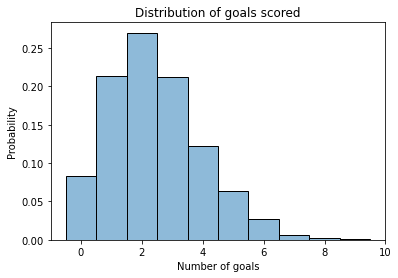

In [8]:
plot_hist(sample_poisson)
decorate_goals()

If the average is 2.4, it is most common to score 1 or 2 goals, less common to score 3 or 4, less common to score 0, and rare to score more than 4.

## The gamma distribution

In the previous section we assume that the goal scoring rate is known, but usually it's something we have to estimate.
If we are not certain what the value of `mu` is, we can use a distribution to represent possible values and their relative likelihoods.

To represent this distribution, I will use a gamma distribution.
That's not the only option, but the gamma distribution is a reasonable choice because:

* The values in a gamma distribution are continuous and non-negative, so that's appropriate for representing a goal-scoring rate.

* As we'll see, the shape of the gamma distribution is consistent with what we know about goal scoring in games like hockey.

The shape of the gamma distribution is controlled by two parameters, `alpha` and `beta`.
I'll assign them values now, and at the end of the fourth notebook, we'll see where they came from!

In [9]:
alpha = 4.6
beta = 1.9

I'll use PyMC again to draw a sample from this distribution.

In [10]:
sample_gamma = pm.Gamma.dist(alpha, beta).random(size=1000)

And here's what it looks like.

In [11]:
import seaborn as sns

def plot_kde(sample, **options):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **options)

In [12]:
def decorate_rate(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    legend()

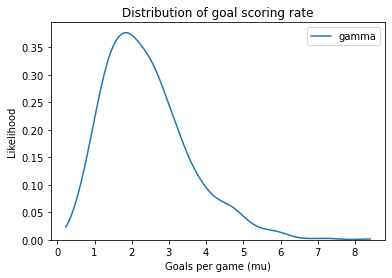

In [13]:
plot_kde(sample_gamma, label='gamma')
decorate_rate()

This distribution represents possible goal-scoring rates for one team against another.
When the worst team plays the best team, their goal-scoring rate might be close to 0.
When the best team plays the worst, their goal-scoring rate might be 8 goals per game, or more.
But for most teams, we expect goal-scoring rates near 2.

## Making a model

As we've seen, we can use PyMC to generate random values from a distribution.
But it is more common to use PyMC to create a `Model`, which is an object that represents random quantities and the relationships between them.

We'll start with a model that contains only one random quantity, and work our way up.

In [14]:
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    trace1 = pm.sample_prior_predictive(1000)

The first line creates an empty model.
The `with` statement creates a context so that the quantities we creates inside are added to the model.

This model contains a `Gamma` distribution with the name `mu` and the parameters `alpha` and `beta`.

Then it uses `sample_prior_predictive` to generate a sample from this distribution.
I'll explain the name of this function soon.

The result is a "trace", which is like a dictionary that maps from names to samples.
If we select the name `mu`, we get a sample from the gamma distribution.

In [15]:
sample_prior = trace1['mu']
sample_prior.mean()

2.4011387700243962

In this example, the gamma distribution is the prior distribution of `mu`; that is, it represents our knowledge of goal-scoring rates in general, rather than the goal-scoring rate of one team against another.

In other words, if we don't know which two teams are playing, this distribution represents what we would believe about `mu`.
And here's what it looks like.

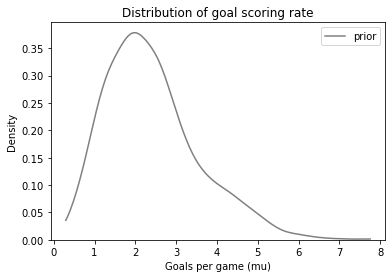

In [16]:
plot_kde(sample_prior, color='gray', label='prior')
decorate_rate('Density')

Other than random variation, it looks the same as the distribution we generated in the previous section.

## Adding to the model

Again, a model represents random quantities and the connections between them.
So let's add another quantity and a connection.

Here's a model that represents the distribution of `mu` *and* the distribution of goals scored.

In [17]:
with pm.Model() as model2:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace2 = pm.sample_prior_predictive(1000)

As in the previous model, `mu` is a goal-scoring rate drawn from a gamma distribution.
And now `goals` is the number of goals scored in a particular game, drawn from a Poisson distribution.

And, crucially, notice the connection between them: the parameter of the Poisson distribution is the value of `mu`drawn from the gamma distribution.

PyMC provides a function that represents a model as a graph that shows the connections between quantities.

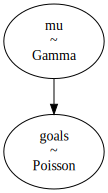

In [18]:
pm.model_to_graphviz(model2)

Remember that `mu` is a rate in goals per game, and `goals` is an integer number of goals.

The distribution of `mu` from this model is the **prior distribution**, which we saw in the previous section.

The distribution of `goals` is the **prior predictive distribution**, because it represents the number of goals we would predict, based on the prior distribution of `mu`.

Let's see what it looks like:

In [19]:
sample_prior_pred = trace2['goals']
sample_prior_pred.mean()

2.368

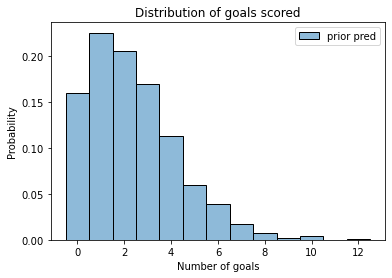

In [20]:
plot_hist(sample_prior_pred, label='prior pred')
decorate_goals()

The prior predictive distribution represents two sources of uncertainty:

* We are not sure what the goal-scoring rate, `mu`, is.

* Even if we knew `mu`, we would not be sure how many goals would be scored in a particular game.

Compared to the Poisson distribution we started with, with known `mu`, the mean of the prior predictive sample is about the same.

In [21]:
sample_poisson.mean(), sample_prior_pred.mean()

(2.426, 2.368)

But the standard deviation is bigger.

In [22]:
sample_poisson.std(), sample_prior_pred.std()

(1.530530626939559, 1.9059317931132793)

The prior predictive distribution shows the distribution of goals we should expect in a game, based on the prior distribution only, not the data.

It is useful for model-checking, but it is also a step along the way to inference.

## When do we get to inference?

So far, we have been modeling the system *forward*; that is, given the distributions and their parameters, we've been generating possible outcomes.

Now we'll start running the model *backward*; given an actual outcome, we will estimate what the parameters might have been.
This process is called **inference**.

And here's where we discover the power of PyMC. 
Since we have already specified the model, we can use it for inference with just two changes:

* Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data.

* And instead of calling `sample_prior_predictive`, we'll call `sample`.

For data, let's assume that Team A plays Team B and scores 4 goals.
Here's how we add it to the model:

In [23]:
with pm.Model() as model3:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace3 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


The output provides information about how the sampling process worked.
The result is a `trace` object similar to the one from the last model.
The differences are:

* Since we provided observed data for `goals`, the trace does not contain a random sample of goals.

* The values of `mu` in the trace are a sample from the **posterior distribution**, which represents what we believe about `mu` based on the data.

We select the sample from the trace in the same way:

In [24]:
len(trace3['mu'])

2000

In [25]:
sample_posterior = trace3['mu']
sample_posterior.mean()

2.978778258874917

The mean of the posterior distribution is higher than the mean of the prior.
And here's what it looks like:

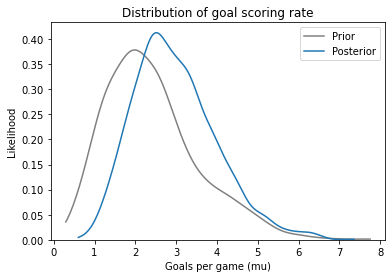

In [26]:
plot_kde(sample_prior, label='Prior', color='gray')
plot_kde(sample_posterior, label='Posterior')
decorate_rate()

The mean of the prior distribution is about 2.4.
The team scored 4 goals, which is more than expected, so the posterior distribution is shifted to the right.

The mean of the posterior distribution is about 3, so it falls between the prior expectation and the observed outcome.

We can also use ArviZ to visualize the posterior distribution and compute summary statistics.

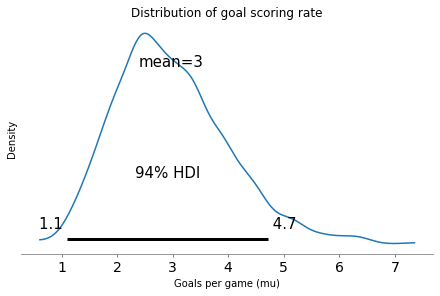

In [27]:
import arviz as az

az.plot_posterior(sample_posterior)
decorate_rate('Density')

The 94% HDI is a **credible interval** that covers 94% of the posterior distribution. Based on the outcome of a single game, there is a 94% chance that the actual goal-scoring rate falls in this range (at least under the assumptions of the model).

**Exercise:** The example we've run so far is based on three parameters: the values of `alpha` and `beta` that determine the prior distribution, and the observed number of goals.

Modify any of these variables and run the example again to see what effect they have.

## Two teams

We can extend the model to estimate different values of `mu` for two teams.

As an example, suppose Team A scores 5 goals and Team B scores 1. The following model estimates their goal scoring rates against each other.

In [28]:
alpha = 4.6
beta = 1.9

In [29]:
with pm.Model() as model4:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1])

Here's the graphical representation of this model.

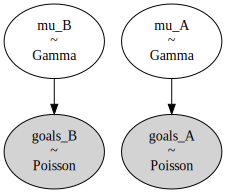

In [30]:
pm.model_to_graphviz(model4)

And now we can run the sampler.

In [31]:
with model4:
    trace4 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


We can use `plot_trace` to review the results and do some visual diagnostics.

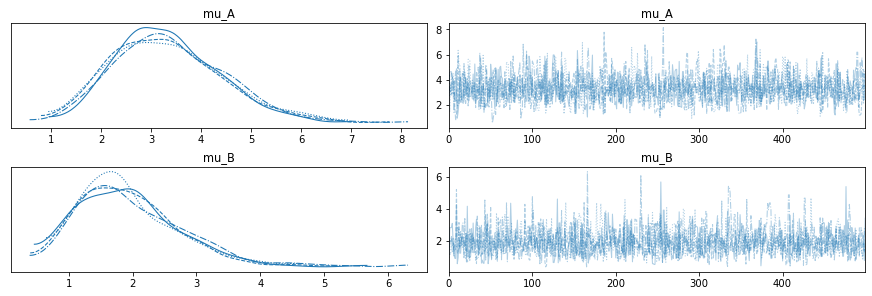

In [33]:
with model4:
    az.plot_trace(trace4)

There are two things to check for:

* Since each sampling chain is trying to sample from the same distribution, their results should be similar. If there are large deviations between them, that can be a sign of trouble.

* The sequence of values should looks like random noise; if it looks like the sampler gets stuck for a while, that's a sign of trouble, too.

For this model, I expect the results to look pretty good.

Here are the posterior distribitions for `mu_B` and `mu_A`.

In [34]:
mu_A = trace4['mu_A']
mu_B = trace4['mu_B']
mu_B.mean(), mu_A.mean()

(1.9426961698474807, 3.3338668957789968)

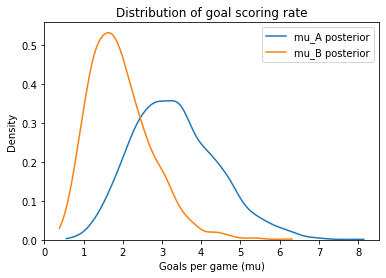

In [35]:
plot_kde(mu_A, label='mu_A posterior')
plot_kde(mu_B, label='mu_B posterior')
decorate_rate('Density')

## Probability of superiority

On the basis of one game, how confident should we be that Team A is the better team?
One way to answer this question is to compute the **probability of superiority**, which is the chance that a random value from the Team A posterior distribution exceeds a random value from the Team B posterior distribution.

In [36]:
(mu_A > mu_B).mean()

0.8575

With a 5-1 result, we have some confidence that Team A is better, but it is not certain.

**Exercise:** Suppose the same teams play again and Team A wins 3-1.
Modify the previous example to take into account both games. How much does the second game affect the posterior distributions and the probability of superiority?

Hint: The observed data can be a list.